The best collection of papers on the net I have found is http://www.cs.unc.edu/~welch/kalman/. From there, the best understandable explanation (from which much of this is derived) is SIGGRAPH2001_CoursePack_08.pdf by Welch and Bishop. The theory part mostly follows the references, especially CoursePack 08, but is in my own words, and describes my own understanding, insights, and sometimes lack of understanding. The example parts at the end are my own work.

# Problem form

We will work with an uncontrolled system, one in which you have no influence on, and you are just trying to observe. For example, take my day job. I work with the EVE instrument on the SDO spacecraft. It observes the current flux of ultraviolet in a particular wavelength from the Sun. The EVE instrument is attempting to measure this, but nothing the SDO satellite (or mankind as a whole) does has any influence at all on what the Sun is actually doing. We can control how well EVE works, but in this case, EVE is just an observer, passively trying to measure something it has no influence over.

The system is presumed to have an internal *state*, an ordered set of numbers (a vector) which completely describes the part of the system we care about. We want to know this state, but it is hidden from us, and cannot be known directly. In the EVE example, the state is the actual UV flux on the Sun at a particular instant. On a robot, it is the current position and velocity of the vehicle.


We make a certain set of observations at one particular instant. Each of these observations is also a vector, but there may be more, less, or the same number of components as in the state. The observations help us learn about the state, but the observations are corrupted by measurement noise, and so do not perfectly describe the state. In the EVE example, the observation is the number of DNs (Data Numbers, the units of the raw value reported by an Analog-to-Digital converter) that the instrument records at a particular instant. A robot may use accelerometers, gyros, GPS, compasses, odometers, etc. This number may be calibrated into some physical unit, but still has an unavoidable amount of noise on it.


We take a vector of measurements at many different times. In the EVE example, the system measures the UV flux four times per second continually. A robot reads some or all of its sensors simultaneouslely, and each measurement is a component of the measurement vector for this time. The units of the components of the vector don't have to match, and the vector doesn't have to be the same measuremente each time. For instance, sometimes we will read our accelerometers and gyros and get a 6-element vector of measurements. Much less frequently we will read our compass and get a 1-element vector. Perhaps even less frequently we will read our GPS and get a 6-element vector, but different from that produced by our IMU.


We use a Kalman filter to combine what we have estimated about state from previous observations, with the data we get from the current observation, to provide a better estimate of the state at the current observation time.

In math terms, the system is described as a set of matrix equations

$$
\def\M#1{{[\mathbf{#1}]}}
\def\MM#1#2{{[\mathbf{#1}{#2}]}}
$$

$$\begin{eqnarray*}
\vec{x}_i&=&\M{A}\vec{x}_{i-1}&+\vec{w}_i \\
\vec{z}_i&=&\M{H}\vec{x}_i&+\vec{v}_i
\end{eqnarray*}$$


where:

* $\M{?}$ is any matrix $\MM{A}{_i}$
* $\vec{?}$ is any vector. Whenever a vector is involved in matrix algebra, it is treated as a column vector, IE an $n \times 1$ matrix.
* $i$ is the step index. As far as the problem is concerned, we have an initial state at $i=0$, then measurements subsequently at $i=1$, $i=2$, $i=3$... and so on. It's kind of like time, but not measured in seconds. In this particular form of the problem, the system exists in some pre-determined state at some $i$, and then instanteaneously jumps to a new state at \(i+1\), where we measure it again. In any real system, the physics probably evolve over time, but as we will see, the filter math just doesn't care, and it is surprising how flexible this kind of "time" is. When we translate this all to code, we will find that $i$ is usually just a name, and we don't even have a variable representing $i$. The filter is mostly just concerned with values $?_i$ from this step and $?_{i-1}$ for the previous step.
* $\vec{x}_i$ is the (unknown) actual state of the system at step $i$. This is an $n$-dimensional vector, or one with $n$ components.
* $\M{A}$ is the state transition matrix. Given a previous state, the state transition matrix is used to transform it to the current state. Since it operates on an $n$-dimensional vector and returns an $n$-dimensional vector (the number of components in the state never changes) it must be an $n \times n$ square matrix. This matrix might change between measurements, but the filter presumes that it is constant.
* $\vec{w}_i$ is the (unknown) process noise, an $n$-dimensional Gaussian random vector with a zero mean and covariance matrix $\M Q$. This is uncertainty in the process itself, unrelated to measurement. It implies that the next state is not perfectly determined by the previous state. Since the process noise is compatible with addition to the state vector, it must be a vector with $n$ components, and its covariance must be a matrix with $n \times n$ components.
* $\vec{z}_i$ is the measurement vector for measurement $i$. This is an $m$-dimensional vector, where m may be greater than, less than, or equal to $n$. Unlike $n$, $m$ may change from step to step, if different kinds of measurements are taken at different steps.
* $\M H$ is the observation matrix. Given a state, the observation matrix is used to transform it to an observation vector. Since it operates on an $n$-dimensional vector and returns an $m$-dimensional vector (the number of components of the observation may be different than the number of components of the state) it must be an $m \times n$ matrix. This matrix might change between measurements, but the filter presumes that it is constant. As above, the size of the matrix, in particular the number of rows, may change from step to step but must always be compatible with the current measurement.
* $\vec{v}_i$ is the (unknown) measurement noise, an m-dimensional Gaussian random vector with a zero mean and covariance matrix $\M R$. Since the measurement noise is compatible with addition to the measurement vector, it must be a vector with $m$ components, and its covariance must be a matrix with $m \times m$ components.

The dimensions $m$ and $n$ are independent, but once chosen, all vectors and matrices must use the correct values to keep all the matrices and vectors compatible with the operations they are used with.

The state transition matrix and observation matrix are designed by you, the problem solver. You need to look at the dynamics of your problem, and see if they fit in this model, and if so, what are $\M A$ and $\M H$. This is how the problem is described to the filter. If you think of the filter as a function, then $\M A$ and $\M H$ are two parameters passed to the function. You also need to provide process noise $\M Q$ and measurement noise $\M R$. Together, these four matrices completely describe the problem model. This is the hardest part of the problem. If you can't shoehorn your problem into this form (and most of the time, you probably can't) you need a nonlinear filter, which is the subject of another notebook. Keep reading this one though, as you need to understand a linear filter as a pre-requisite to understanding a nonlinear filter.

## A word on history
Normally I aggressively ignore history. In this case I can't, because a man's name is built into the name of the topic. If I just called it the "sequential filter" (as I have seen in textbooks occasionally) no one would know what I was talking about, and I wouldn't get any Google hits.

### Why Kalman?
Many people reached the New World before Columbus. The Vikings, the Nephites, the Jaredites, perhaps others, etc. However, Columbus is properly said to have discovered the New World, because his discoveries made it into modern main-stream thought, and all further exploitation of the New World is as a result of him and his journeys. He discovered the New World so well that no one ever needed to discover it again, and no educated person could credibly claim to do so.

Likewise, through a phenomenon I have heard called ''Jungian simultaneity'', many people derived the formulas we now call the Kalman filter almost simultaneously. However, Rudolph Kalman's paper directly influenced the work of the guidance guys at MIT for the Apollo mission and perhaps other secret missions. Therefore, the filter is named after him by those who put it into practice.

Rumor has it that Kalman met at a conference and discussed ideas with other people who wrote papers which also described the sequential filter. Who is to say whether the idea was original or not? I don't want to get into this controversy, which is why I would like to call it the sequential filter rather than Kalman filter, but for reasons described above, I can't.

### Why filter?
Because it filters out noise from a measurement stream. The estimate stream produced by the filter can have much less uncertainty than the measurement stream coming in.

One of the amazing things about this filter, and estimation in general, is that it also filters out quantization noise. Under certain conditions, it is possible to get an estimate of the true state with less noise and uncertainty than any of the measurements that went into it. Ponder that deeply. The filter makes it possible to talk about fractions of a DN, about the space between the symbols produced by your ADC.

### Filter mathematical definition

This mostly follows Welch & Bishop, except uses $i$ instead of $k$ so as to not conflict in a non-case-sensitive language (like IDL) with Kalman gain coefficient $\M K$.

Our filter tries its best to come up with an estimate of what the real state is. We know that this estimate is imperfect, but it is the best the filter can do. For a problem which actually matches this model, and the proper definition of "best", it is provable that the Kalman filter really does compute the best possible estimate given the noise in the measurements.

What follows is a recipe, light on derivations and proofs. Just follow it, without trying to understand it too much. I understand 1,2, and 4 below, but not 3 and 5. I have learned through sad experience that it is difficult to test a program step-by-step if you don't know what the intermediate steps are or how to calculate them. We will discuss testing in a later post.

#### Symbol definitions

* $\hat{?}$ Estimated value of unknown variable $?$. In code, we will usually say ``?hat``. In general, an estimated variable is named the same as the unknown true variable, with the addition of ``hat``. If the variable is a vector, we will use the compound symbol $\hat{\vec{?}}$. Notice that even if it is a vector, it is not necessarily one of unit length.
* $?^-$ Updated value. Some variable $?$ is updated from the previous step to the current step, but the new measurement is not used in this process, so no new information is available from it. It's just the old value projected to the current step. This 'minus' is usually a superscript in textbooks, but we will almost always use it with vectors and matrices, and draw it as the last symbol inside the brackets of the matrix in question, so we will never confuse it with subtraction.
* $\M{?}^T$ Transpose of matrix $\M ?$
* $\M{?}^{-1}$ Inverse of square matrix $\M ?$

#### Time update

First, we project the state ahead, to get an estimate of what the state is at the current measurement, based on our best estimate at the previous measurement:

$$\hat{\vec{x}}^-_i=\M A\hat{\vec{x}}_{i-1}$$

where:

* $\hat{\vec{x}}^-_i$ is the updated previous estimate of the state

Next, we project the state covariance matrix forward:

$$\MM{P}{^-_i}=\M{A}\MM{P}{_{i-1}}\M A^T+\M Q$$

where:

* $\MM{P}{_i}$ is the estimate error covariance at step $i$, the covariance of the uncertainty in our estimate of the state. This value is an estimate, but customarily doesn't have a hat, because there is no corresponding "real" value for it. The state has a real value with zero uncertainty at each point, but we can't see it, except imperfectly through the measurements. This matrix is our estimate of how good our estimate is.
* $\MM{P}{^-_i}$ is the updated estimate error covariance.

The idiom $\M A \M P \M A^T$ is how any covariance matrix $\M P$ is propagated with a transition matrix $\M A$. It isn't just $\M A\M P$ since $\M P$ is a covariance, wich matches what we think of in scalar form as variance $\sigma^2$ and not standard-deviation $\sigma$, as it is in the square of the units of $\vec{x}$. If we think about a scalar, we really want $(A\sigma)^2=A^2\sigma^2$ or in matrix form, $\M A^2\M P$. In order to come out with a matrix in the right shape, we do $\M A^2 \M P$ as $\M A \M P\M A^T$. Some textbooks refer to this as the similarity transformation.

So this error projection makes sense. The projected covariance is simply the old covariance transformed by the state transition matrix, plus the process noise we think is there.

Once done, we think we know where the state is at this measurement, based on the state at the last measurement.

#### Measurement

We next calculate the the difference between what we did measure and what we should have measured, based on our updated state estimate. This is called is called the residual (or measurement innovation)

$$\vec{y}=\vec{z}_i-\M H\hat{\vec{x}}^-_i$$

The matrix $\M H$ transforms a state into a measurement. As mentioned in the previous post, you provide this matrix, depending on the form of your problem and the sensors your robot has. We'll see more about this in the examples. As we will see, we never need to solve the much harder problem of transforming a measurement into a state, because that is part of what the filter is there to do for us. The problem is already solved.

The residual is an $m$-dimensional vector (same size as the observation vector). We know that the state estimate is uncertain, since we have its covariance $\M P$. So, even if the measurement was perfect, we would expect there to be some residual between the perfect measurement and our estimate of the measurement based on our imperfect state estimate. We don't know the error, but we do know the uncertainty, so we can talk about the covariance of the residual. Therefore there is a component of residual uncertainty caused purely by the uncertainty in our state estimate. The total residual uncertainty can't possibly be smaller than this. We also know that the measurement is imperfect, since we have *its* covariance $\M R$. The error in the measurement contributes to the residual, and the uncertainty of the measurement adds its own component to the measurement uncertainty. So, we figure the covariance of the residual (an $m$ by $m$ matrix) just by adding those two components.

$$\M{\Gamma}=\M H\MM{P}{^-_i}\M H^T+\M R$$

$\M \Gamma$ (Greek capital gamma) is a matrix which we can think of as the estimate covariance transformed into observation space (similarity transformation again), and then with the measurement uncertainty added.  This time the transformation is from one space to another, instead of forward in time, but it's still the same form, so the similarity transformation still applies.

#### Measurement update

We define the cross-covariance matrix between the error in the state estimate and the residual (No, I don't know what this means, but some papers call out this matrix) as:

$$\M S=\MM{P}{^-_i}\M H^T$$

Now we incorporate the information from our current measurement. We calculate the Kalman Gain, which is the weighting function used to determine how much we believe the updated estimate, and how much we believe the measurement.

$$\M K=\M S\M \Gamma^{-1}$$

where

* $\M K$ is the Kalman gain for this measurement. By working through the matrix operations, we see that this must be an $n$ by $m$ matrix. The derivation for the gain includes some kind of justification for this in this produces a maximum-likelyhood estimate in some Bayesian sense, but I don't understand it fully.

Note that the Kalman gain is used both to weight that residual, and to transform it back from observation space to state space. It's tempting but wrong to think of the weighting of the residual as done with the $\M \Gamma^{-1}$ matrix, and the transformation back to state space as the rest. If you think about it in scalar terms, it says that the larger the residual covariance is, the less you weight it. 

Using this gain, we calculate the new state estimate:

$$\hat{\vec{x}}_i=\hat{\vec{x}}^-_i+\M K\vec{y}$$

Finally we calculate the new estimate error covariance:

$$\MM{P}{_i}=\left(\M 1-\M K\M H\right)\MM{P}{^-_i}$$

where $\M 1$ is the $n$ by $n$ identity matrix which is compatible with the rest of the formula.

This matrix is useful in itself when publishing formal uncertainties, but even if you don't care, the filter cares, because it needs this uncertainty to balance the old estimate with the new measurement.

#### The Five-Line Form

Customarily, several of these equations are combined, to give the five-line form of the Kalman filter. This is the form which you will probably use to write your program.

$$\begin{eqnarray*}
\hat{\vec{x}}^-_i&=&\M A\hat{\vec{x}}_{i-1} \\
\MM{P}{^-_i}&=&\M A\MM{P}{_i-1}\M A^T+\M Q \\
\M K&=&\MM{P}{^-_i}\M H^T\left(\M H \MM{P}{^-_i}\M H^T+\M R\right)^{-1} \\
\hat{\vec{x}}_i&=&\hat{\vec{x}}^-_i+\M K\left(\vec{z}_i-\M H\hat{\vec{x}}^-_i\right) \\
\MM P{_i}&=&\left(\M 1-\M K\M H\right)\MM{P}{^-_i} \\
\end{eqnarray*}$$

### Examples

As noted above, the hard part is adapting your problem to the filter's form. To do that requires practice, so let's work through a few examples.

Let's just measure something, like the voltage across a resistor, with an analog-to-digital converter. We'll ignore the discrete nature of an ADC for now and say that our ADC converts a voltage into an unlimited-precision real number. However, like all real devices, it is imperfect, and while it gives unlimited precision, it only has finite accuracy.

We presume that the voltage is constant.

So, let's reiterate our model, and see how this problem matches up with it.

$$\begin{eqnarray*}
\vec{x}_i&=&\M A \vec{x}_{i-1}+\vec{w}_i\\
\vec{z}_i&=&\M H \vec{x}_i+\vec{v}_i
\end{eqnarray*}$$

The state $\vec{x}_i$ is the actual voltage. It is a one-dimensional vector, or in other words just a scalar. This means that $n=1$.

The state transition $\M A$ describes how the state changes with time. Since the state is one dimensional, the state transition is scalar also. Since the voltage is constant, the constant is $A=1.0$ exactly.

The process noise is theoretically an uncertainty in the state, but is mostly just used for tuning. For now, we will say that the covariance (scalar) $\M Q$ on it is $Q=0$.

The measurement $\vec{z}_i$ is supposed to just be the voltage, so the observation (scalar) $\M H$ is also $H=1.0$ exactly.

We will say that the measurement uncertainty is normal with a 0.1 standard deviation. This makes the measurement noise has a covariance (scalar) $\M R$ is $R=0.01$ .

Now we re-iterate the filter equations, just so you don't have to skip around so much to read things.

$$\begin{eqnarray*}
\hat{\vec{x}}^-_i&=&\M A\hat{\vec{x}}_{i-1} \\
\MM{P}{^-_i}&=&\M A\MM{P}{_i-1}\M A^T+\M Q \\
\M K&=&\MM{P}{^-_i}\M H^T\left(\M H \MM{P}{^-_i}\M H^T+\M R\right)^{-1} \\
\hat{\vec{x}}_i&=&\hat{\vec{x}}^-_i+\M K\left(\vec{z}_i-\M H\hat{\vec{x}}^-_i\right) \\
\MM P{_i}&=&\left(\M 1-\M K\M H\right)\MM{P}{^-_i} \\
\end{eqnarray*}$$

So, let's plug our filter matrices which are really scalars, turn the crank, have a cancelfest, and see what we get:

$$\begin{eqnarray*}
x^-_i&=&x_{i-1}\\
P^-_i&=&P_{i-1} \\
K_i&=&\frac{P^-_i}{P^-_i+R}\\
x_i&=&x^-_i+K_i(z_i-x^-_i)\\
P_i&=&(1-K_i)P^-_i
\end{eqnarray*}$$    

Well, that cleans up quite nicely. Let's have a closer look at it. First off, our projected state estimate is just our old state estimate, since we don't expect it to change. Our projected estimate covariance likewise doesn't change.

Since the measurement uncertainty and the estimate covariance are always positive, we see that the denominator of the Kalman gain term is always larger than the numerator, and thus that the gain is always between zero and one. It can only reach those extremes if either the measurement uncertainty or estimate uncertainty is zero, and neither is.

Updating the estimate is interesting in this scalar case. We have the new estimate $x_i=x^-_i+K_i(z_i-x^-_i)$. In this case, we start with our baseline new estimate being our old estimate. We then add a term which is a fraction of the measurement, and subtract a term which depends on our old estimate. If $K_i$ was one, we would end up with $x_i=x^-_i+z_i-x^-_i$, which means that the old estimate completely cancels out and the new estimate is just the new measurement. This is what it means to completely trust the measurement. Conversely, if $K_i$ was zero, we would end up with $x_i=x^-_i+(0)z_i-(0)x^-_i$ and we wouldn't change the estimate at all. This is what it means to completely trust the estimate and distrust the measurement. 

In short, if the Kalman gain were exactly one, the fourth equation says that our new estimate would be exactly our measurement. If it were zero, we would ignore the measurement.

Obviously this will become much more complicated and interesting with nontrivial $\M A$ and $\M H$ matrices, but the principle remains the same. $\M K$ is "larger" when we trust the measurement more, and "smaller" (or "closer to $\M 0$") when we trust the estimate more.

We notice that the estimate uncertainty does not depend on the measurement, only the measurement uncertainty. Likewise with the Kalman gain. So, knowing the *a priori* estimate uncertainty and measurement uncertainty, we can predict their future history without regard to the measurements themselves. We see from the last equation that the next uncertainty is always smaller than the current one, and therefore the Kalman gain will continually decrease. Sounds like an exponential decay to me.

By combining equations 3 and 5, we get:

$$P=\frac{RP^-}{R+P^-}$$

If we look for convergence, the $P$ on the left side is the same as the $P^-$ on the right. Taking $R$ as a constant, we get

$$\begin{eqnarray*}
P(R+P)&=&RP \\
RP+P^2&=&RP \\
    P^2&=&0 \\
    P&=&0 
\end{eqnarray*}$$

meaning that the only fixed point is at zero. Combining this with the knowledge that $P$ continually decreases, we can predict with certainty that $P$ collapses to zero. This actually makes sense. If you think about how intuitively we know that the uncertainty of a large number of measurements is proportional to $1/\sqrt{N}$, in the limit the uncertainty will collapse to zero as we take an infinite number of measurements.

Once $P$ collapses like this, $K$ will also, as $P$ is in its numerator. When $K$ collapses, this means that the measurement will be ignored, and the estimate will match the previous estimate.

It's pretty easy to code all that up. Let's say that the true measurement is 0.5V, the *a priori* estimate is zero with a variance of 1. Then we can do this:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.random

def sim_noise(n=1000,sigma=0.1,seed=3217):
    numpy.random.seed(seed)
    return numpy.random.randn(n)*sigma

def sim_constant(n=1000,sigma=0.1,seed=3217):
    #True value of state
    val=0.5
    #Measurement noise
    noise=sim_noise(n,sigma,seed)
    #State at all measurement times
    x=noise*0+val
    #All measurements
    z=x+noise
    return (x,z)

def kalman_scalar(x,z,R=0.01,P0=1,xh0=0):
    #Record of estimate over time
    xh=np.zeros(z.shape)
    P=np.zeros(z.shape)
    K=np.zeros(z.shape)
    P[0]=P0
    xh[0]=xh0
    for i in range(1,z.size):
        #Execute the five-line Kalman filter equations
        xhm=xh[i-1]
        Pm=P[i-1]
        K[i]=Pm/(Pm+R)
        xh[i]=xhm+K[i]*(z[i]-xhm)
        P[i]=(1-K[i])*Pm
    return (xh,P,K)


By running this, we get this:

<IPython.core.display.Javascript object>


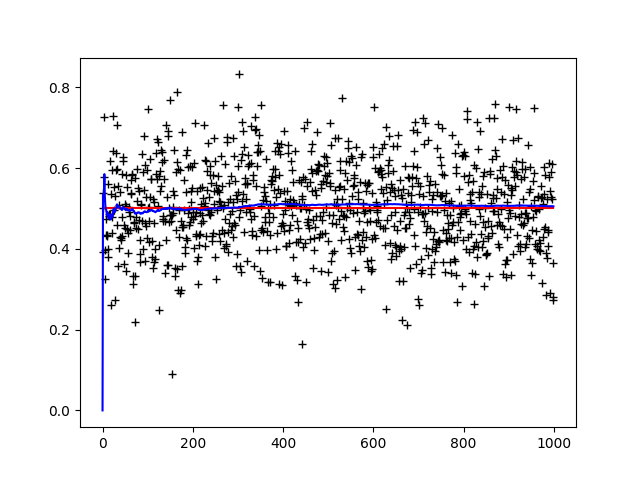

<IPython.core.display.Javascript object>


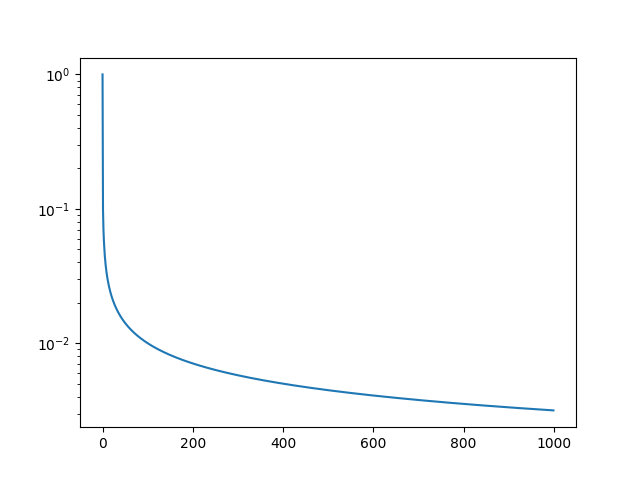

<IPython.core.display.Javascript object>


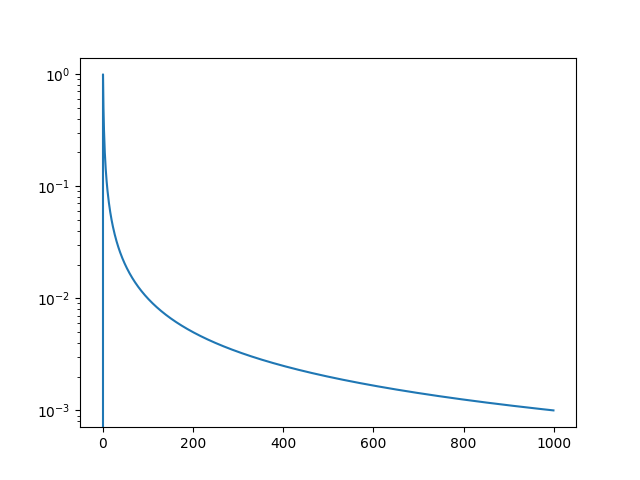

In [2]:
(x,z)=sim_constant()
(xh,P,K)=kalman_scalar(x,z)
plt.figure("Constant Measurements")
plt.plot(z,'k+')
plt.plot(x,'r-')
plt.plot(xh,'b-')
plt.figure("Constant 1-sigma uncertainty")
plt.semilogy(np.sqrt(P))
plt.figure("Constant Kalman gain")
plt.semilogy(K)
plt.show()


The black crosses are 1000 measurements, the red line is the true state value, and the blue line is the Kalman estimate at each measurement, each point only considering the points to the left.


We see that even though the filter started with a very inaccurate state estimate, and the measurements themselves are very inaccurate, the filter converged to near the correct answer very quickly, for appropriate values of "very".


With these particular measurements, we get at our last estimate:

In [3]:
print("x=%f±%fV"%(xh[-1],np.sqrt(P[-1])))

x=0.505009±0.003164V


This uncertainty is very near that predicted by the 1/sqrt(N) model:

In [4]:
print(0.1/np.sqrt(xh.size))

0.0031622776601683794


One of the interesting things about the Kalman filter is that the state uncertainty $\M P$ only depends on the measurement uncertainty $\M R$, not the actual measurement. There is no feedback from the actual size of the residual to the state uncertainty. So, if we ran the filter again with different noise, we would get a different state estimate, but a bit-for-bit identical uncertainty:

In [5]:
(x_1,z_1)=sim_constant(seed=1)
(xh_1,P_1,_)=kalman_scalar(x_1,z_1)
print("x=%f±%fV"%(xh_1[-1],np.sqrt(P_1[-1])))
print("P difference: %f"%(P[-1]-P_1[-1]))

x=0.503717±0.003164V
P difference: 0.000000


Looking at a plot of the inverse of the Kalman gain (effectively the weighting on the previous estimated state) it is just linear. So, this is just a fancy averager.

### Disclaimer

It is a great disservice to Kalman and all those who developed the filter into what it is today, to call it a simple averager. Yes, it reduces to an averager in the simple case, but the filter also works in the complicated case. It has all the statistical properties that you want, and if you tell the truth about all the filter inputs, the filter output really is optimum. I am just trying to understand the filter, and running it on simple cases helps.

### Process Noise

If we know that the constant really is a constant, then what we did before is just fine, but we might as well just do an average. Suppose however, that our constant isn't really constant. Suppose it has a step in it. If you think about the filter as an averager, an averager never forgets. The filter result will end up the weighted average between the measurements before the step and the measurements after.

<IPython.core.display.Javascript object>


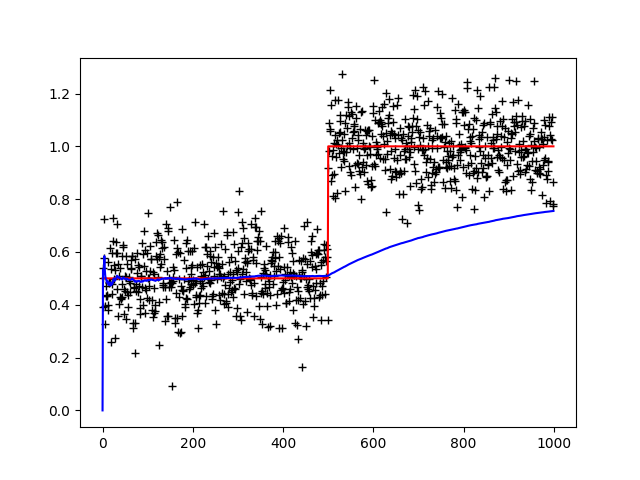

x=0.755257±0.003164V


In [6]:
def sim_step(n=1000,x0=0.5,x1=1,sigma=0.1,steppos=500,seed=3217):
    #Measurement noise
    numpy.random.seed(seed)
    noise=numpy.random.randn(n)*sigma
    #State at all measurement times
    x=noise*0
    x[:steppos]+=x0
    x[steppos:]+=x1
    #All measurements
    z=x+noise
    return (x,z)

(x,z)=sim_step()
(xh,P,K)=kalman_scalar(x,z)
plt.figure("Step Measurements")
plt.plot(z,'k+')
plt.plot(x,'r-')
plt.plot(xh,'b-')

print("x=%f±%fV"%(xh[-1],np.sqrt(P[-1])))

As mentioned before, there is no feedback from the actual residual size to the estimate uncertainty. As a result, the filter's estimate is quite far off, while its uncertainty is still the same size as before, and therefore the estimate error is many times the estimate uncertainty.

So, what we can do is give the filter a little uncertainty, a little nagging doubt, about its previous results. We tell it that its estimate of the estimate error covariance is a little bit wrong. We create a little bit of doubt that the system really is a rock solid constant. 

We add *process noise*.

Reiterating the Kalman filter again in all its glory, let's reduce it again, but this time include the process noise term.

$$\begin{eqnarray*}
\hat{\vec{x}}^-_i&=&\M A\hat{\vec{x}}_{i-1} \\
\MM{P}{^-_i}&=&\M A\MM{P}{_i-1}\M A^T+\M Q \\
\M K&=&\MM{P}{^-_i}\M H^T\left(\M H \MM{P}{^-_i}\M H^T+\M R\right)^{-1} \\
\hat{\vec{x}}_i&=&\hat{\vec{x}}^-_i+\M K\left(\vec{z}_i-\M H\hat{\vec{x}}^-_i\right) \\
\MM P{_i}&=&\left(\M 1-\M K\M H\right)\MM{P}{^-_i} \\
\end{eqnarray*}$$

Once again, a cancelfest:

$$\begin{eqnarray*}
x^-_i&=&x_{i-1}\\
P^-_i&=&P_{i-1}+Q \\
K_i&=&\frac{P^-_i}{P^-_i+R}\\
x_i&=&x^-_i+K_i(z_i-x^-_i)\\
P_i&=&(1-K_i)P^-_i
\end{eqnarray*}$$    

Now the estimate covariance never collapses to zero. In fact, it never decreases below the process covariance $Q$, which is what we would expect. If the process really is uncertain, our estimate can never be less than that uncertainty.

Lets sic this on the true constant first, to see what we give up:

<IPython.core.display.Javascript object>


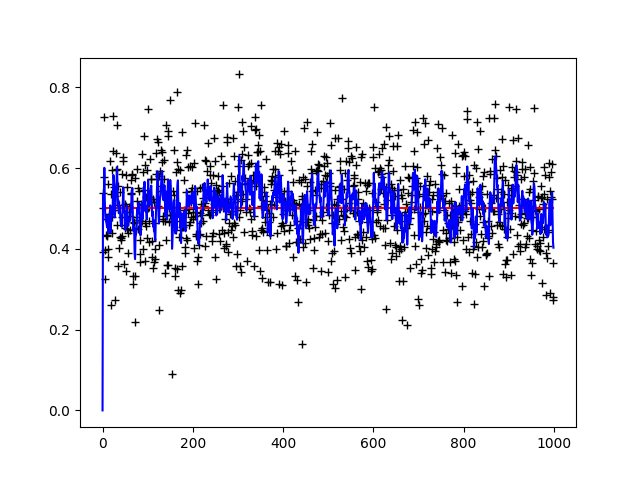

<IPython.core.display.Javascript object>


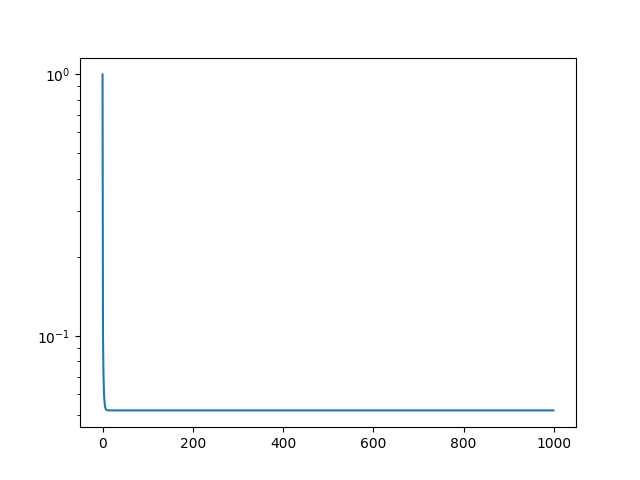

<IPython.core.display.Javascript object>


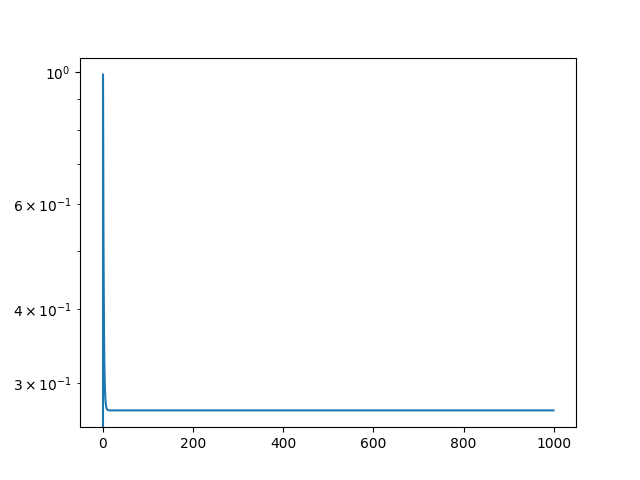

x=0.402798±0.051977V
K=0.270156, memory=2.701562


In [7]:
def kalman_pn_scalar(x,z,Q=0,R=0.01,P0=1,xh0=0):
    #Record of estimate over time
    xh=np.zeros(z.shape)
    P=np.zeros(z.shape)
    K=np.zeros(z.shape)
    P[0]=P0
    xh[0]=xh0
    for i in range(1,z.size):
        #Execute the five-line Kalman filter equations
        xhm=xh[i-1]
        Pm=P[i-1]+Q  #This is the only change, adding Q
        K[i]=Pm/(Pm+R)
        xh[i]=xhm+K[i]*(z[i]-xhm)
        P[i]=(1-K[i])*Pm
    return (xh,P,K)

(x,z)=sim_constant()
(xh,P,K)=kalman_pn_scalar(x,z,Q=0.001)
plt.figure("Constant Measurements and process noise")
plt.plot(z,'k+')
plt.plot(x,'r-')
plt.plot(xh,'b-')
plt.figure("Constant 1-sigma uncertainty with process noise")
plt.semilogy(np.sqrt(P))
plt.figure("Constant Kalman gain with process noise")
plt.semilogy(K)
plt.show()

print("x=%f±%fV"%(xh[-1],np.sqrt(P[-1])))
print("K=%f, memory=%f"%(K[-1],(1-K[-1])/K[-1]))

Naturally our uncertainty is a lot worse, since the filter thinks that the process really is uncertain about what its state is. It weighs the previous estimate quite a bit less than it did when the process was rock solid. Also notice that with this particular seed, we are unlucky with the last few measurements. There is a bias below the actual value, and as a result the estimate is about 1.8 sigma away from the truth. Not great, but not impossible.

As it turns out, once the filter converges, it weighs the previous estimate about three times heavier than the current measurement, so in a way its memory only extends for three measurements. The filter in this case is a moving average of the recent past, where older measurements' weight decays exponentially.

Let's see how it does now against a step in the constant:

<IPython.core.display.Javascript object>


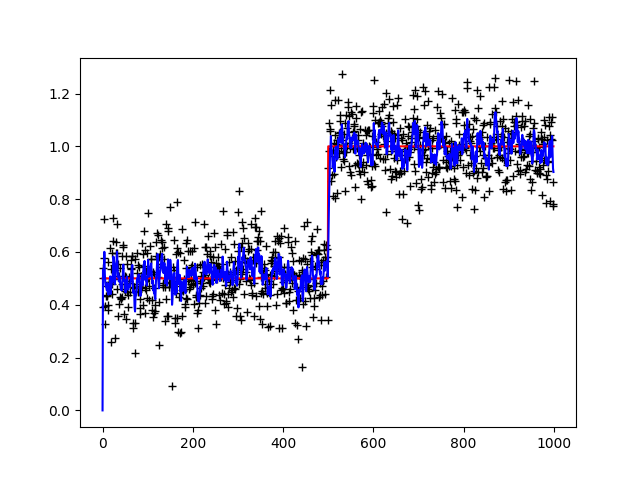

In [8]:
(x,z)=sim_step()
(xh,P,K)=kalman_pn_scalar(x,z,Q=0.001)
plt.figure("Step Measurements and process noise")
plt.plot(z,'k+')
plt.plot(x,'r-')
plt.plot(xh,'b-')
plt.show()

Since it only remembers back about three measurements, it only takes about three measurements to start tracking the new value.

Process noise represents our uncertainty about what the process really is doing, uncertainty about our model. But, how can you assign a standard deviation to "maybe the constant has a step in it"? It certainly doesn't have a normal distribution. The right answer is to fix the process model, but maybe we can't. In this case, we use the process noise level as just a tuning parameter. We can tune it to get the right balance between noise filtering and responsiveness to change. In the above examples, the process noise is rather large, only 1/sqrt(10) of the measurement noise (Q=0.001, R=0.01). Let's see what happens as we turn the process noise down. All of these have the same measurement covariance, only the process covariance changes.

<IPython.core.display.Javascript object>


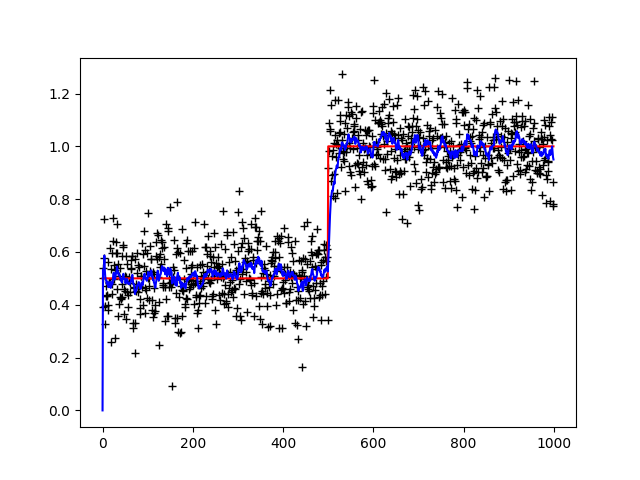

Q=1.000000e-04, memory about 9.512492 steps


<IPython.core.display.Javascript object>


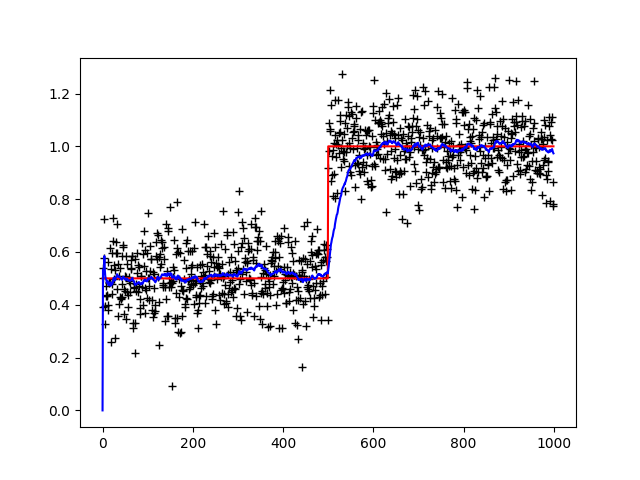

Q=1.000000e-05, memory about 31.126729 steps


<IPython.core.display.Javascript object>


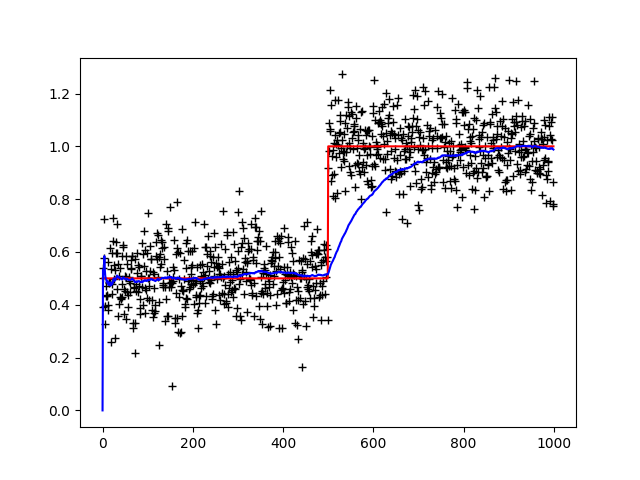

Q=1.000000e-06, memory about 99.501250 steps


In [9]:
def test_pn(Q):
    (x,z)=sim_step()
    (xh,P,K)=kalman_pn_scalar(x,z,Q=Q)
    plt.figure("Step Measurements and process noise Q=%e"%Q)
    plt.plot(z,'k+')
    plt.plot(x,'r-')
    plt.plot(xh,'b-')
    plt.show()
    print("Q=%e, memory about %f steps"%(Q,(1-K[-1])/K[-1]))

test_pn(Q=1e-4)
test_pn(Q=1e-5)
test_pn(Q=1e-6)


So we see that as we turn the process noise down, the estimate in the flat part becomes smoother, in exchange for the response to the new data becoming longer.

This kind of tuning is a judgement call. It's actually an ugly hack, and should be avoided if possible, but it may not be possible.

### Kalman Velocity Model
Pay attention here, because we are finally going to develop something practical - The Kalman Velocity Model

This is about the only problem I have found which both has a practical use, and actually fits the linear model.

Let's imagine a rail car on a level frictionless rail. The car is unpowered and uncontrollable, but is subject to unpredictable accelerations (say from gusts of wind). We want to know the position and velocity of the car, but our only measuring device is a tape measure laid out along the track. Once again we can measure the position of the car to arbitrary position, but only finite accuracy.

First, let's look at the process model again:

$$\begin{eqnarray*}
\vec{x}_i&=&\M A\vec{x}_{i-1}+\vec{w}_i \\
\vec{z}_i&=&\M H\vec{x}_i+\vec{v}_i
\end{eqnarray*}$$

Now that we are considering motion, we need to consider time. The time interval between two measurements $\vec{z}_{i-1}$ at $t_{i-1}$ and $\vec{z}_i$ at $t_i$ we will call $\Delta t=t_i-t_{i-1}$ (Delta-t). It doesn't matter if $\Delta t$ is constant from step to step, but it is meaningless to think of $\Delta t$ changing in a single step. If we consider $\Delta t$ to be constant, it means that we have equally-spaced measurements.

The state of the vehicle is completely determined by its current position $p$, and velocity $v$, so its state vector is:

$$\vec{x}=\begin{bmatrix}p \\ v\end{bmatrix}$$

The state transition matrix is two-by-two, since the state is two-element. In simple linear equation language, we have this:

$$\begin{eqnarray*}
p_{i}&=&p_{i-1}+\Delta t &v_{i-1}\\
v_{i}&=&                 &v_{i-1}
\end{eqnarray*}$$

Converting this to a matrix equation gets us this:

$$\begin{eqnarray*}
\begin{bmatrix}p \\ v\end{bmatrix}&=&\begin{bmatrix}1 & Δt \\0&1\end{bmatrix}&\begin{bmatrix}p_{i-1} \\ v_{i-1}\end{bmatrix}\\
\vec{x}_i&=&\M A&\vec{x}_{i-1}
\end{eqnarray*}$$

so we have a state transition matrix:

$$\M A=\begin{bmatrix}1 & \Delta t \\ 0 & 1\end{bmatrix}$$

For the observation matrix, we are taking the two-component state and converting it to one measurement, so the matrix is one-by-two.

$$\begin{eqnarray*}
\vec{z}_i&=&(1)p_i+&(0)v_i \\
         &=&\begin{bmatrix}1 & 0\end{bmatrix}&\begin{bmatrix}p_i \\v_i \end{bmatrix}\\
         &=&\M H&\vec{x}_i \\
\end{eqnarray*}$$

so the observation matrix is:

$$\M H=\begin{bmatrix}1 & 0\end{bmatrix}$$

### Process Noise Model

We represent the unpredictable accleration component with the process noise covariance matrix. The process noise is a random vector variable with two elements, so its covariance is a two-by-two matrix. I will borrow the process noise model from Wikipedia. In between any two measurements, the unknown process noise acceleration is presumed to be constant $a_i$. Since it is unknown, we model it as a Gaussian random variable with mean 0 and standard deviation $\sigma_a$. By integrating this over the time step, we see that the velocity is changed by $a_i\Delta t$ and by integrating twice we see that the position is changed by $\frac{1}{2}a_i\Delta t^2$.

So in mathematical terms, if we knew $a_i$, we could perfectly update the state and get:

$$\begin{eqnarray*}
\vec{x}_i&=&\M A\vec{x}_{i-1}+\vec{w}_i \\
\vec{w}_i&=&\begin{bmatrix}\frac{a_i \Delta t^2}{2} \\ a_i \Delta t\end{bmatrix}\\
         &=&\begin{bmatrix}\frac{\Delta t^2}{2} \\ \Delta t\end{bmatrix}a_i\\
\vec{g}&=&\begin{bmatrix}\frac{\Delta t^2}{2} \\ \Delta t\end{bmatrix}\\
\vec{x}_i&=&\M A\vec{x}_{i-1}+\vec{g}a_i\\
\end{eqnarray*}$$

This comes straight from [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter#Example_application,_technical) underived. The process noise covariance matrix is

$$\begin{eqnarray*}
\M Q&=&\vec{g}\vec{g}^T\sigma_a^2 \\
    &=&\begin{bmatrix}\frac{\Delta t^4}{4} & \frac{\Delta t^3}{2}\\\frac{\Delta t^3}{2} & \Delta t^2\end{bmatrix}σ_a^2
\end{eqnarray*}$$

Here I use $\vec{?}^T$ for the row vector form of column vector $\vec{?}$, IE we treat the column vector as an $n \times 1$ matrix and transpose it. I don't know the exact derivation, but basically it is saying that since the standard deviation is known, and the variance is required, you just square the standard deviation. Since you can't directly square a vector, the idiom $\vec{g}^2=\vec{g}\vec{g}^T$ is used.

As we look through the filter equations, it turns out that $\M Q$ is always added to the projected value of $\M P$, so it doesn't matter if $\M Q$ is singular by itself. 

In this case the process noise is a real part of the model, and not an ugly hack or tuning parameter. We defined the model with this random acceleration, and this process noise matrix describes it in math. For real systems such as EVE, the process noise is still an ugly hack.

The measurement is a scalar, so its covariance is scalar also.

$$R=\sigma_z^2$$

We can then apply these matrices directly to the Kalman filter form.

### Sensor fusion and sensor anti-fusion

In this  simple model, we have only one kind of sensor, for position, but we are able to recover both position and velocity. This is possible because our physics model $\M A$, simple as it is, is complete and captures the whole state vector. It also passes the *observability* criterion, a concept for another day. 

This concept is important. If your system is observable (and that can be determined solely by looking at $\M A$ and $\M H$), you don't necessarily need a sensor for every component of your state vector. This is sensor anti-fusion, I guess. It is a complementary concept to sensor fusion.

With sensor fusion, sensors of two different types are used to measure the same parts of the state vector. We'll get into exactly how to do this in a later post, but let's just talk about goals for a moment. Suppose your robot has a 6DOF IMU and a GPS. You use the IMU for accuracy over short distances and times, and the GPS to keep things aligned with the real world, and keep the IMU from wandering off too far.

Now, you are probably not going to measure the GPS and IMU at the same time. So, for some steps, perhaps most steps, the IMU measurement is available and the GPS is not. Other steps, the GPS is available and the IMU is not. Perhaps there are rare times when both measurements are taken simultaneously.

What you do in this case is use a different observation model, and therefore a different $\M H$ depending on what combinations of sensors are available at a particular instant. When you use the IMU, you have an $\M H$ (or actually the nonlinear equivalent of $\M H$) which only uses the IMU. You also have the measurement uncertainty of the IMU in its own $\M R$. When you use the GPS, you use a different $\M H$. And, when both are available simultaneously, you could use an $\M H$ that incorporates both. We'll see why we don't do that at a later time.

With the right $\M H$ for each measurement and the right $\M A$ (or its nonlinear equivalent as we shall see) for the physics, combined with the correct measurement noise for each measurement, the filter does all the bookkeeping and weighting automatically to incorporate multiple different kinds of sensors into the same estimate. It automatically weights each measurement to use it as best as possible. If you don't lie with $\M R$, it is able to weigh things appropriately without any further intervention. This is what is meant by sensor fusion.

### EVE example

Now this process noise we have applied is just a model, just a fudge factor to keep the filter from getting too satisfied with itself. The filter thinks the process has noise, but in reality that noise is the process not following the model. I am not prepared to [tell the sun what to do](https://en.wikipedia.org/wiki/King_Canute_and_the_tide).

Here's an example using the velocity process above, applied to the EVE instrument. The filter uses this process noise model, but the real data does not. During a measurement sequence of 1000 measurements, the Sun generates a rock solid constant 20 units of flux for the first half. At the exact halfway point, we see a flare begin. This flare has a maximum amplitude of 20 units, and then decays away again.

The EVE instrument is modeled as having a Gaussian uncorrelated measurement noise with a standard deviation of one unit, with the following exception: On a randomly selected 1% of the measurements, the standard deviation is five units. This represents an actual phenomenon seen on EVE.

$$\begin{eqnarray*}
\hat{\vec{x}}^-_i&=&\M A\hat{\vec{x}}_{i-1} \\
\MM{P}{^-_i}&=&\M A\MM{P}{_i-1}\M A^T+\M Q \\
\M K&=&\MM{P}{^-_i}\M H^T\left(\M H \MM{P}{^-_i}\M H^T+\M R\right)^{-1} \\
\hat{\vec{x}}_i&=&\hat{\vec{x}}^-_i+\M K\left(\vec{z}_i-\M H\hat{\vec{x}}^-_i\right) \\
\MM P{_i}&=&\left(\M 1-\M K\M H\right)\MM{P}{^-_i} \\
\end{eqnarray*}$$

<IPython.core.display.Javascript object>


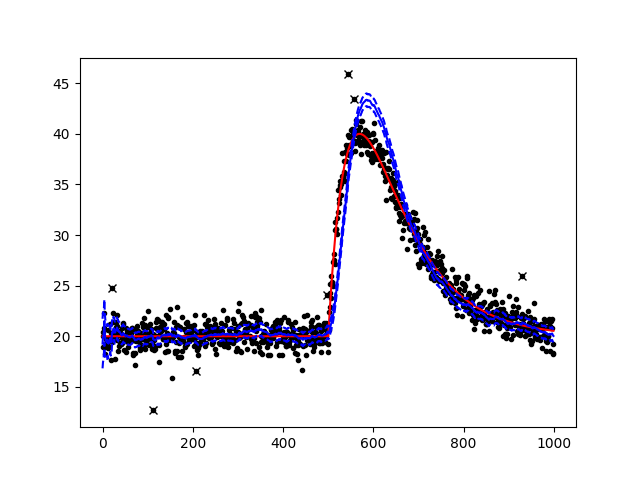

In [10]:
def kalman(A,H,Q,R,xhm1,Pm1,z):
    """
    Do one time and measurement update
    :param A: State Transition matrix
    :param H: Measurement matrix
    :param Q: Process noise covariance
    :param R: Measurement noise covariance
    :param xhm: Previous state estimate
    :param Pm: Previous state covariance
    :param z: Measurement vector
    """
    from scipy.linalg import inv
    xhm=A@xhm1
    Pm=A@Pm1@A.T+Q  
    K=Pm@H.T@inv(H@Pm@H.T+R)
    xh=xhm+K@(z-H@xhm)
    P=(np.eye(xhm.size)-K@H)@Pm
    return (xh,P,K)

def kalman_velocity(dt,z,xh0,P0,sig_z,sig_a=0.00001):
    """
    Do an entire series of Kalman filter measurements 
    :param dt: Time between steps
    :param z: Observations - 1D p-element numpy array
    :param xh0: Initial state estimate - 1D n-element numpy array
    :param P0: Initial covariance - 2D n x n element numpy array
    :return: A tuple:
      [0] - xh - 2D n x p numpy array, each column of which is a state estimate at a measurement
      [1] - P - 3D n x n x p numpy array, each slice of which is a covariance at a measurement
      [2] - K - 3D n x 1 x p numpy array, each slice of which is a Kalman gain matrix
    """
    p=z.size
    n=xh0.size
    xh=np.zeros((n,p))
    P=np.zeros((n,n,p))
    K=np.zeros((n,1,p))
    dt=1
    A=np.array(((1,dt),(0,1)))
    H=np.array(((1,0),))
    Q=np.array((((dt**4)/4,(dt**3)/2),((dt**3)/2,dt**2)))*sig_a**2
    R=np.array(((sig_z**2,),))
    for i,zi in enumerate(z):
        if i==0:
            xhm1=xh0.reshape(n,1)
            Pm1=P0
        else:
            xhm1=xh[:,i-1].reshape(n,1)
            Pm1=P[:,:,i-1]
        (this_xh,this_P,this_K)=kalman(A,H,Q,R,xhm1,Pm1,np.array(((zi,),)))
        xh[:,i]=this_xh.reshape((n,))
        P[:,:,i]=this_P
        K[:,:,i]=this_K
    return (xh,P,K)

def sim_popcorn_noise(n=1000,popcorn_frac=0.01,popcorn_factor=5,sigma=None,seed=3217):
    numpy.random.seed(seed)
    noise=numpy.random.randn(n)*sigma
    popcorn_select=numpy.random.random(n)
    w=np.where(popcorn_frac>popcorn_select)[0]
    noise[w]*=popcorn_factor
    return noise,w

def sim_flare(n=1000,sigma=1,seed=3217,val=20,flareamp=20):
    #Measurement noise
    (noise,w)=sim_popcorn_noise(n=n,sigma=sigma,seed=seed)
    #State at all measurement times
    x=noise*0+val
    dxdt=noise*0
    a=100
    b=100
    t=np.arange(n//2)
    flare=np.exp(-t/a)*(1-np.exp(-t/b))
    flare=flareamp*flare/np.max(flare)
    dflaredt=(flare[1:]-flare[:-1])/1
    x[n//2:]+=flare
    dxdt[n//2:-1]+=dflaredt
    dxdt[-1]=dflaredt[-1] #Repeat the last value as best estimate of derivative at last point
    #All measurements
    z=x+noise
    return (x,z,w,dxdt)


sig_z=1
sig_a=0.001
(x,z,w,dxdt)=sim_flare(sigma=sig_z)
plt.figure("Flare")
plt.plot(z,'k.')
plt.plot(w,z[w],'kx')
plt.plot(x,'r-')
(xh,P,K)=kalman_velocity(dt=1,z=z,xh0=np.array((20,0)),P0=np.array(((1,0),(0,1))),sig_z=sig_z,sig_a=sig_a)
plt.plot(xh[0,:],'b-')
plt.plot(xh[0,:]+3*np.sqrt(P[0,0,:]),'b--')
plt.plot(xh[0,:]-3*np.sqrt(P[0,0,:]),'b--')


The heavily marked points are the 1% "popcorn" (There might not be exactly 10, since they are thrown in at random). The red line represents reality again, and the blue line represents the filter output. We notice immediately that the filter has less noise than the original data, so the filter is working. We also notice that while the filter output follows the popcorn, it is not nearly as bad as the original data itself.

Here is a plot of the estimate difference from the real measurement. The solid line is the filter residual, and the light lines are the ±3-sigma uncertainty lines. As long as the dotted lines bracket zero, we are within 3 sigma of the truth.

<IPython.core.display.Javascript object>


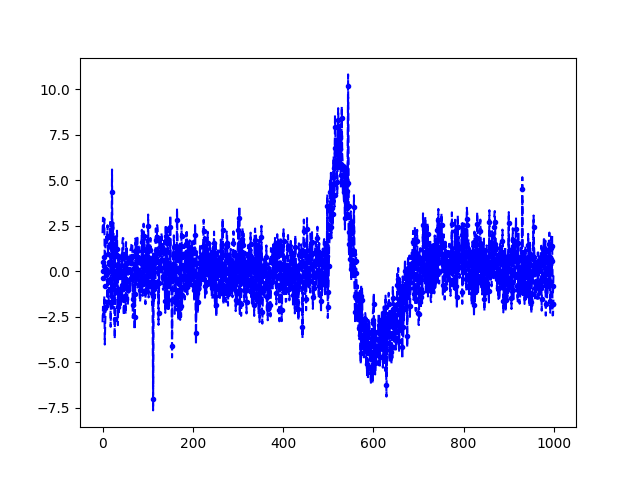

In [11]:
plt.figure("Position residuals")
plt.plot(z-xh[0,:],'b.')
plt.plot(z-xh[0,:]-3*np.sqrt(P[0,0,:]),'b--')
plt.plot(z-xh[0,:]+3*np.sqrt(P[0,0,:]),'b--')
plt.show()

The problem here is that the filter takes a while to believe that the process really changed, so it lags a bit behind the actual process. This is that large downward spike we see at the half way point. Other than that, the filter has a standard deviation of about a third that of the original data, and the 3-sigma lines include the actual value almost all the time, as it should.


The process includes a notion of velocity, the rate of change of the flux, but this is not a measurement that EVE actually makes. Even so, the filter provides a velocity estimate automatically. We could estimate it, but no one has asked for it. Perhaps if the scientists know that it is available, they will want it.

<IPython.core.display.Javascript object>


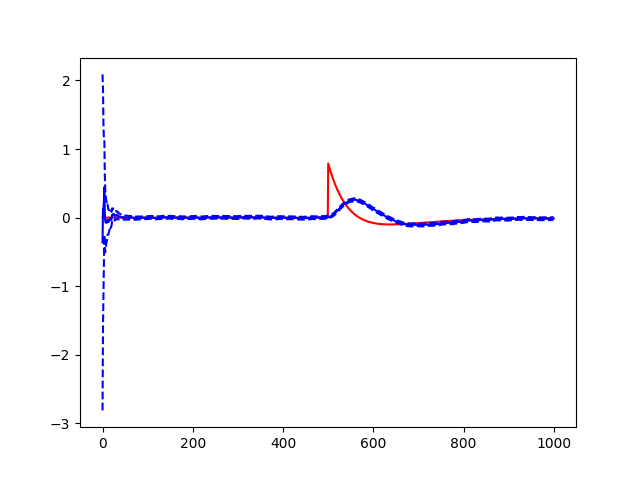

In [12]:
plt.figure("Velocity")
plt.plot(dxdt,'r-')
plt.plot(xh[1,:],'b-')
plt.plot(xh[1,:]+3*np.sqrt(P[1,1,:]),'b--')
plt.plot(xh[1,:]-3*np.sqrt(P[1,1,:]),'b--')
plt.show()

This is very educational as to what the problem is. The real flux (literally) explodes, with a step jump in velocity. The filter takes a while to follow, and by the time it has followed, the flux velocity is dropping rapidly, and once again the filter has to chase it.

### Testing your filter

Unless you are a much better programmer than me, and I don't think you are, when you originally code this up, it is going to have bugs. Now the normal way to debug is to trace the program flow, and at every line, or at least every critical line, *predict* what the program is going to do then test it by letting it execute. However, if you don't understand the algorithm, how can you do this prediction?

This is why we are going step by step, with gradually more elaborate filters, each built off the last. I gave Python code for a scalar Kalman filter in a previous section. This simplest filter was devolved to the point that all the magic in equations 3 and 5 has been distilled out, leaving only an obvious averager. Then, as you add refinements one at a time, test frequently. When it breaks (and it will) you know what part is broken: the last one you added, or at least an interaction between that part and the rest of the code.

You need to work with the code to understand it, and the best way is to evolve the code a step at a time as I have. You are guided by the examples, but you put in the effort yourself to follow them. It's all very Socratic.

There is no excuse to not have Python -- it is free and exists for every major (and many minor) platforms out there. However, if Python is not your favorite language, you can program the simpler models even in a spreadsheet, and the more complicated one in your favorite data-handling language, or even general purpose language like C, Java, or Perl. If your language has no native charting abilities, have your filter write its output into a CSV, then suck it into a spreadsheet. There's no excuse, as C, Java, Perl, and OpenOffice are all free for the taking and available on almost all platforms (even your robot, if you write in C).

As you progress, you will come to the point where you will write a general Kalman filter function, which can handle any process model thrown at it. At this point, you will then be debugging your models. Before you try to debug on your robot, try using $\M A$ and some initial conditions to simulate a robot trajectory and using $\M H$ to generate measurements at frequent intervals. This way, the normally unknowable True State is in fact known, and you can compare your estimate with the Truth, in a way which is almost impossible otherwise.

### The usefulness of this model

By itself, we can use this model to estimate the rate of change of any variable that we can measure. If you have a thermometer, you can use the filter to not only reduce the measurement noise, but also create out of thin air a measurement of the rate of change. Likewise the voltage and charge state of your battery, the altitude and climb/sink rate measured by an ultrasonic pinger used as an altimeter, or any number of things.

Further, when I describe the nonlinear filter and IMU model, you will see this model embedded in that one. The filter will integrate the acceleration to get velocity and position, but the acceleration it integrates will not be the direct measurement of the sensor, but an estimate based on the linear velocity model.

# Sensor Fusion
There is nothing that says that our problem definition matrices, $\M A$, $\M H$, $\M Q$, and $\M R$ have to be constant from one step to the next. They have to be constant in one step, but they can be different in the next step. In fact, the *measurement size* $m$ doesn't even have to be constant. Suppose we have a cart model like above, but now we do have a direct speed measurement (like from a [flyball governor](https://en.wikipedia.org/wiki/Centrifugal_governor) attached to an encoder). 

If the two measurements are always taken in sync, then $m=2$ and we use an $\M H$ matrix which is $(2 \times 2)$ to determine both the position and velocity measurements from the state vector. In this simple case, $\M H$ probably is just the right-sized identity matrix, but there is no reason to not have off-diagonal terms in the general case.

If however, the measurements are not taken in sync, we do the following:

1. Do a time update to the time of the next measurement, whichever it is.
2. Do a measurement update for that kind of measurement. If for instance the position is currently being measured, we use $\MM{H}{_p}=\begin{bmatrix}1 && 0\end{bmatrix}$, while if we have a velocity measurement, we use $\MM{H}{_v}=\begin{bmatrix}0 && 1\end{bmatrix}$. In the first case, we use $\MM{R}{_p}=[\sigma_p^2]$, while in the second case we use $\MM{R}{_v}=[\sigma_v^2]$. Both of these are scalars.
3. If the measurements happen at the same time, we can bump $m$ up to 2 and use our full-blown $\MM{H}{_{pv}}$. In this case, $\M R$ is 2x2, the on-diagonal components are the uncertainty of each component by itself (quantified as the variance $\sigma_p^2$ and $\sigma_v^2$). The off-diagonal components are the covariance between each component, in this case a single value $\rho_{pv}\sigma_p\sigma_v$. But, unless we know otherwise, it is pretty typical to assume that the measurement errors in position and velocity are uncorrelated, $\rho_{pv}=0$, and therefore all the off-diaogonal components of $\M{R}$ are zero.

## Component-wise measurement update
In order to calculate the Kalman gain, we need a matrix inverse. These require a bunch of code, a bunch of time, etc. In Python, that's not a big problem because we generally use Python on big computers with lots of power, and the bunch of code is already tucked into our linear algebra library (probably Numpy). So if you need to do it, it's possible, but note that the effort scales roughly by the size of the *cube* of the measurement vector $m^3$

But, let's take a closer look at the part where we need it:

$$\begin{eqnarray*}
\MM{\Gamma}{_{(m\times m)}}&=&\MM{H}{_{(m\times n)}}\MM{P}{^-_{i,(n\times n)}}\MM{H}{_{m\times n}}^T+\MM{R}{_{m\times m}}\\
\MM{S}{_{(n \times m)}}&=&\MM{P}{^-_{i,(n\times n)}}\MM{H}{_{(m\times n)}}^T \\
\MM{K}{_{(n \times m)}}&=&\MM{S}{_{(n\times m)}}\MM{\Gamma}{_{(m\times m)}}^{-1}
\end{eqnarray*}$$

Let's all spare a thought for those lucky people who have a scalar measurement, IE $m=1$. Their $\M \Gamma$ matrix is a scalar, and inverting a scalar is just division. They don't have to do a matrix inverse at all. If only we could be one of those lucky people...

The reason we can't be that lucky is that in general, there is no way to divide the problem up into scalar measurements, because we have a full-blown $\M R$. But, what if the components of our measurement vector are not correlated? In this case, all of the off-diagonal components are zero. We *can* treat each component as its own scalar measurement.

Note that this is a restriction on the problem -- in full generality, $\M R$ is not diagonal and we will have to do a matrix inverse. However, the correlation between components of the measurement are typically difficult to measure, and we assume (maybe without justification) that the off-diagonal components of $\M R$ are zero. We just assume away the problem.

So, if you have a measurement with $m$ components, you can do this:

1. Time update as normal
2. Measurement update. For each component $i$ of the vector, do the following:
   * Figure $\MM{H}{_i}$ by taking row $i$ of the full matrix $\M H$. The result will be an $1 \times n$ matrix, or an $n$-element row vector.
   * Figure $R_i$ (which will be a scalar now) as $\sigma_i^2$
   * Calculate $\Gamma_i$ (which will be scalar now)
   * Calculate $\MM{S}{_i}$ which will be a $n \times 1$ matrix, or a column vector
   * Calculate $\MM{K}{_i}=\MM{S}{_i}\frac{1}{\Gamma_i}$. Instead of doing a matrix inverse for $\M \Gamma$, we just do a scalar division.
   * Use $\MM{K}{_i}$ to do the measurement update for $\hat{x}$ and $\M{P}$
   * Do not do a time update, because no time has elapsed between this component of the measurement vector and the next.
   
This almost seems too good to be true, as each time, we are updating the whole state with a single component of measurement. What if the state is not observable with the one measurement? Suppose you have a system where the system is not observable given any one state, but is observable with all of them. Does this update work? 

I think that you can prove that it does, because the large matrix multiplies that we are doing for the large system are themselves composed of row operations. I will make the case that we are just explicitly doing the row operations that would be done automatically with the larger operations, and that the combined result of all of our measurement updates will be observable even if each row by itself is not, given that the large matrix measurement update is observable.